In [1]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.cp_rtrbm import RTRBM
from boltzmann_machines.cp_rbm import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *
from data.poisson_data_v import PoissonTimeShiftedData
from utils.moments_plot import infer_and_get_moments_plot

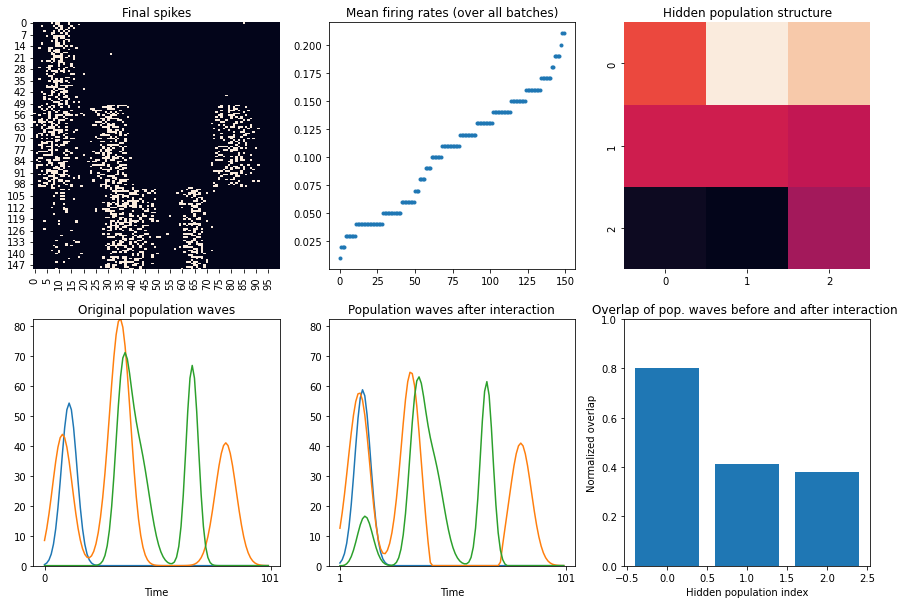

In [4]:
n_populations = 3
neurons_per_population = 50
duration = 1
dt = 1e-2
x = PoissonTimeShiftedData(
    n_batches=1,
    n_populations=n_populations,
    neurons_per_population=neurons_per_population,
    duration=duration, dt=dt,
    fr_mode='gaussian', temporal_connections='random', corr=2,
    fr_range=[50, 100], mu_range=[0, duration], std_range=[2 * dt, 5 * dt], n_range=[0.018, 0.02]
)
data = x.data
axes = x.plot_stats()
plt.show()

In [41]:
#torch.save(x, r'C:\Users\sebas\RU\intern\Figures\data\data_PT_fig2')


<AxesSubplot:>

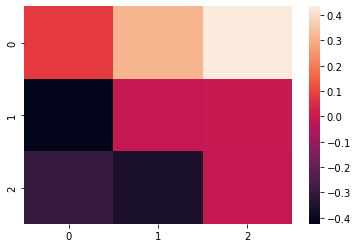

In [2]:
path2file = r'C:\Users\sebas\RU\intern\Figures\data\data_PT_fig2'
def figure_2a_fr(path2file, figsize=(8.27, 11.69), fs=8):
    PMT = torch.load(path2file)

    #fig, axes = plt.subplots(1, 1, figsize=figsize)
    colors = [(0, 80/255, 0/255, 1), (140/255, 170/255, 0, 1),(0/255, 175/255, 60/255, 1)]
    for i, wave in enumerate(PMT.population_waves_interact[..., 0]):
        fig, axes = plt.subplots(1, 1, figsize=figsize)
        colors = [(0, 80/255, 0/255, 1), (140/255, 170/255, 0, 1),(0/255, 175/255, 60/255, 1)]
        axes.plot(wave[68:100], label=str(i+1), color=colors[i], linewidth=0.8)

        #axes.legend(prop={'size': 3}, loc='upper right', frameon=False)
        axes.xaxis.set_ticks([])
        axes.yaxis.set_ticks([])
        #axes[0].set_title('', fontsize=fs)
        #axes.set_ylabel('Firing rate', fontsize=fs)
        #axes[0].yaxis.set_label_coords(-0.08, 0.45)
        #axes.set_xlabel('Time', fontsize=fs)
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
        plt.tight_layout()
        plt.gca()
        plt.savefig(r'C:\Users\sebas\RU\intern\Figures\PM\individual fr\firing_rate_interact_pop_'+str(i)+'.png', orientation = 'portrait', format = 'png', dpi=800, bbox_inches = "tight")

    return plt.gca()
figure_2a_fr(path2file, figsize=(0.1*6.6, 0.5), fs=8)
# plt.savefig(r'C:\Users\sebas\RU\intern\Figures\PM\individual fr\firing_rate_original.png', orientation = 'portrait', format = 'png', dpi=800)

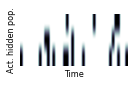

In [36]:
def figure_2a_PMT(path2file, figsize=(8.27, 11.69), fs=8):
    PMT = torch.load(path2file)

    fig, axes = plt.subplots(1, 1, figsize=figsize)
    axes.imshow(abs(1.0 * (PMT.mother_trains[:, 40:80, 0]>0) - 1) , cmap=plt.get_cmap('bone'), aspect='auto')

    axes.xaxis.set_ticks([])
    axes.yaxis.set_ticks([])
    #axes[0].set_title('', fontsize=fs)
    axes.set_ylabel('Act. hidden pop.', fontsize=fs)
    #axes[0].yaxis.set_label_coords(-0.08, 0.45)
    axes.set_xlabel('Time', fontsize=fs)
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.spines['left'].set_visible(False)

    plt.tight_layout()
    return plt.gca()
figure_2a_PMT(path2file, figsize=(0.3*6.6, 1.2), fs=8)
#plt.savefig(r'C:\Users\sebas\RU\intern\Figures\PMT_figure_2a_1.png', orientation = 'portrait', format = 'png', dpi=800)

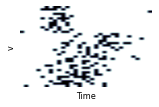

In [65]:
def figure_2a_PT(path2file, figsize=(8.27, 11.69), fs=8):
    PMT = torch.load(path2file)

    fig, axes = plt.subplots(1, 1, figsize=figsize)
    idx = np.random.permutation(50)[:12]
    idx1 = np.random.permutation(50)[:12]
    idx2 = np.random.permutation(50)[:12]
    idx = np.concatenate([idx, idx1+50, idx2+100])
    axes.imshow(abs(PMT.data[idx, 68:100, :]-1) , cmap=plt.get_cmap('bone'), aspect='auto')
    axes.xaxis.set_ticks([])
    axes.yaxis.set_ticks([])
    #axes[0].set_title('', fontsize=fs)
    axes.set_ylabel('v', fontsize=fs)
    #axes[0].yaxis.set_label_coords(-0.08, 0.45)
    axes.set_xlabel('Time', fontsize=fs)
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.spines['left'].set_visible(False)

    plt.tight_layout()
    return plt.gca()
figure_2a_PT(path2file, figsize=(0.35*6.6, 1.6), fs=8)
plt.savefig(r'C:\Users\sebas\RU\intern\Figures\Neural_Activity_figure_2a_PM.png', orientation = 'portrait', format = 'png', dpi=800)


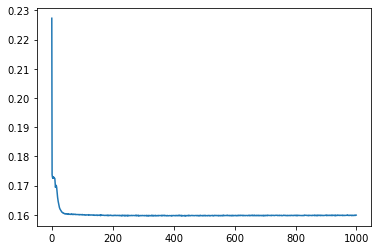

In [29]:
path2file =r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Paper\Surrogate_data\PM'
s, train, test = torch.load(path2file + '\PMT_train_test_corr10_n0')
rbm_path = path2file + r'\rbm_corr10_n0'
rtrbm_path = path2file + r'\rtrbm_corr10_n0'

rbm = torch.load(rbm_path)
rtrbm = torch.load(rtrbm_path)
plt.plot(rtrbm.errors)


100%|██████████| 70/70 [01:49<00:00,  1.56s/it]


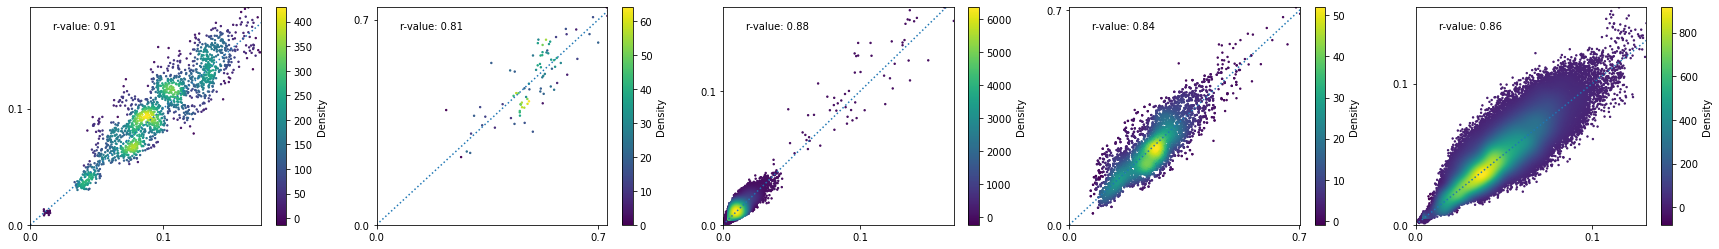

In [70]:
_, _, vh = infer_and_get_moments_plot(dir=path2file+ r'\rtrbm_corr10_n0', machine='rtrbm', test=test, pre_gibbs_k=10, gibbs_k=100, mode=1, n=10000, m=100000)
[vt, vs, ht, hs] = vh
vt, vs, ht, hs = np.array(vt), np.array(vs), np.array(ht), np.array(hs)

min, max tick on color bar: -292.06445, 5356.863


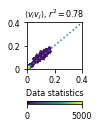

In [72]:
def figure_2c_moments(x, y, fs=8, ax=None, fig=None, r=None, sort=True, bins=20, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x, y]).T,
                method="splinef2d", bounds_error=False)

    # To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0
    if r is None:
        r = np.corrcoef(x, y)[0, 1]**2
    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    print('min, max tick on color bar: ' + str(min(z)) + ', ' +str(max(z)))
    ax.scatter(x, y, c=z, s=0.5, **kwargs )
    norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm), ax=ax, ticks=[-290, 5350], orientation='horizontal', pad=0.35)
    # cbar.ax.set_ylabel('Density', fontsize=fs)
    cbar.ax.set_xticklabels(['0', '5000'], fontsize=fs)

    ax.plot([0, 1], [0, 1], ':')
    maxi = 0.4#max(np.max(x), np.max(y))
    ax.set_xlim([0, 1 * maxi])
    ax.set_ylim([0, 1 * maxi])
    ax.set_xticks([0, 0.2, 0.4], fontsize=fs)
    ax.set_xticklabels(['0', '0.2', '0.4'], fontsize=fs)
    ax.set_yticks([0, 0.2, 0.4], fontsize=fs)
    ax.set_yticklabels(['0','0.2', '0.4'], fontsize=fs)
    ax.set_title('$\langle v_iv_j \\rangle $, $r^2={:.2f}$'.format(r), fontsize=fs)
    ax.set_xlabel('Data statistics', fontsize=fs)
    # ax.set_ylabel('Model statistics', fontsize=fs)
    #ax.text(.05, .77, '$r^2$-value: {:.2f}'.format(r), transform=ax.transAxes, fontsize=fs)
    return ax

fig, ax = plt.subplots(1, 1, figsize=(0.15*6.6, 1.7))
# figure_2c_moments(x=np.mean(vt,1), y=np.mean(vs,1), ax=ax, fig=fig)
figure_2c_moments(x=np.array(np.matmul(vt, vt.T) / vt.shape[1]).flatten(),
                  y=np.array(np.matmul(vs, vs.T) / vs.shape[1]).flatten(), ax=ax, fig=fig)
# plt.savefig(r'C:\Users\sebas\RU\intern\Figures\PM\First_moment_figure_2c_rtrbm.png', orientation = 'portrait', format = 'png', dpi=800, bbox_inches = "tight")
plt.savefig(r'C:\Users\sebas\RU\intern\Figures\PM\Second_moment_figure_2c_rtrbm.png', orientation = 'portrait', format = 'png', dpi=800, bbox_inches = "tight")

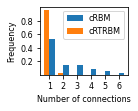

In [28]:
def figure_2d_sparcity(rbm_path, rtrbm_path, figsize=(8.27, 11.69), fs=8, th=0.2):
    rbm = torch.load(rbm_path)
    rtrbm = torch.load(rtrbm_path)
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    label_list = ['cRBM', 'cRTRBM']
    dx = [0.3, 0.7]
    dr = [0.4]
    for i, machine in enumerate([rbm, rtrbm]):
        x = dx[i]
        label = label_list[i]
        W = np.array(machine.W.cpu().detach().clone())
        W[np.abs(W)<th] = 0
        W[W!=0] = 1
        number_of_connections = np.sum(W, 0)
        count = np.zeros(int(max(number_of_connections)))
        for i in range(int(max(number_of_connections))):
            count[i] = np.sum(number_of_connections == i)

        #axes.bar(np.arange(max(number_of_connections)), count, 0.8)
        # axes.hist(number_of_connections-1, bins=np.arange(7)-0.5, density=True, rwidth=0.8)
        axes.hist(number_of_connections-1, bins=np.arange(7)-x, density=True, rwidth=dr, label=label)
        axes.set_xticks([0, 1, 2, 3, 4, 5])
        axes.set_xticklabels(['1', '2', '3', '4', '5', '6'], fontsize=fs)
        axes.yaxis.set_ticks([0.2, 0.4, 0.6, 0.8])
        axes.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], fontsize=fs)

        #axes[0].set_title('', fontsize=fs)
        axes.set_ylabel('Frequency', fontsize=fs)
        #axes[0].yaxis.set_label_coords(-0.08, 0.45)
        axes.set_xlabel('Number of connections', fontsize=fs)
        # axes.spines['top'].set_visible(False)
        # axes.spines['right'].set_visible(False)
        # axes.spines['bottom'].set_visible(False)
        # axes.spines['left'].set_visible(False)

    plt.tight_layout()
    axes.legend(fontsize=fs)
    return plt.gca()
rbm_path = path2file + r'\rbm_corr10_n0'
rtrbm_path = path2file + r'\rtrbm_corr10_n0'
figure_2d_sparcity(rbm_path, rtrbm_path, figsize=(0.3*6.6, 1.65), fs=8, th =0.3)
# figure_2d_sparcity(rbm_path, rtrbm_path, figsize=(0.4*6.6, 1.65), fs=8, th =0.3)
plt.savefig(r'C:\Users\sebas\RU\intern\Figures\Sparcity_figure_2c.png', orientation = 'portrait', format = 'png', dpi=800)